---

#### Note: Throughout the thesis code/notebooks, to reproduce different results and methods, code cells are edited and desired paramteres entered and re-ran. Code is commented out and in at times when we want to use different variables etc, this saves having lots of repeated code clogging up the notebooks. Output from cells is not always maintained.


---




---

# Installations & Imports


---



In [ ]:
!pip install tensorflow-io
!pip install pydub
!pip install wget
!pip install spectrum_augmenter

# !pip uninstall tensorflow
!pip install keras_tuner
# !pip install tensorflow

ERROR: Could not find a version that satisfies the requirement spectrum_augmenter (from versions: none)
ERROR: No matching distribution found for spectrum_augmenter


In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import librosa
import json
import os 
import wget
import shutil
import tensorflow as tf
import tensorflow_io as tfio

import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')

import matplotlib.pyplot as plt

from pydub import AudioSegment
from pydub.playback import play

# import keras_tuner as kt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
test_id = 'd6560298-c90a-4248-bd02-e911e68e09a8'



---

# Sample Code for Getting spectrograms and SpecAugment with Tensorflow (from docs)



---



In [ ]:
sound = AudioSegment.from_mp3('gdrive/MyDrive/thesis/pop_train_files/2b174447-e190-4f40-9685-cbd511a67f81')
sound = sound.set_channels(1)
sound.export("new.wav", format="wav")


<_io.BufferedRandom name='new.wav'>

In [ ]:
audio = tfio.audio.AudioIOTensor('new.wav')

audio2 = tf.cast(tfio.audio.AudioIOTensor('new.wav').to_tensor(), tf.float32)


print(audio)

<AudioIOTensor: shape=[317075328         1], dtype=<dtype: 'int16'>, rate=44100>


In [ ]:
# lead 5 mins (300 seconds x sampling rate 48000hz)
audio_slice = audio2[:48000*300]

audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([   0.    0.    0. ... 3481. 3139. 2819.], shape=(14400000,), dtype=float32)


In [ ]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

## Plot Graph

tf.Tensor([0.         0.         0.         ... 0.10623169 0.09579468 0.08602905], shape=(14400000,), dtype=float32)


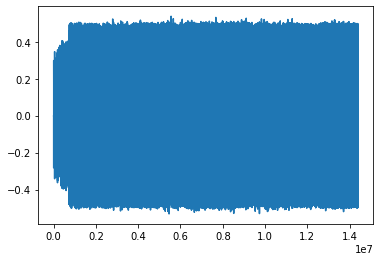

In [ ]:
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())
print(tensor)

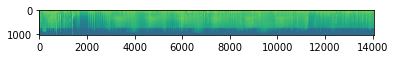

In [ ]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    tensor, nfft=2048, window=2048, stride=1024)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy().T)

In [ ]:
print(spectrogram.shape)

(1875, 513)


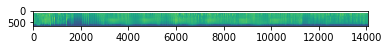

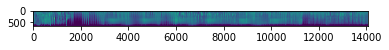

In [ ]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=640, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy().T)

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy().T)
# output_path = "gdrive/MyDrive/thesis/podcast_images/popular/"
# plt.savefig(f"{output_path}{test_id}.png")

In [ ]:
!ls gdrive/MyDrive/thesis/

podcast_data	pop_test_files	 raw_pop_test_files   rclone
podcast_images	pop_train_files  raw_pop_train_files  thesis_code


## SpecAugment

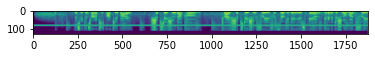

In [ ]:
# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(freq_mask.numpy().T)
output_path = "gdrive/MyDrive/thesis/podcast_images/popular/"
plt.savefig(f"{output_path}{test_id}_freq.png")

In [ ]:
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(time_mask.numpy().T)

output_path = "gdrive/MyDrive/thesis/podcaddst_images/popular/"
plt.savefig(f"{output_path}{test_id}_time.png")

In [ ]:
plt.savefig("popular/" + test_id + '_freq.png')



---

# Functions


---



In [ ]:
def create_audio_sample(file, snippet_size=120):
  """
    Input: full podcast episode (mp3)
    Output: Extract/stitch desired snippet and export as wav file
  """

  audio = AudioSegment.from_mp3(file)
  audio = audio.set_channels(1)

  # pydub does things in milliseconds
  # Take leading snippet size and a snippet from during the podcast
  start = audio[:(snippet_size*1000)]
  midpoint = len(audio)//2
  middle = audio[midpoint : midpoint + (snippet_size*1000)]

  # Export audio sample for preprocessing
  sample = start + middle
  sample.export('new_file.wav', format="wav")


def extract_features(file):
  """
    Input: Wav audio snippet
    Output: audio features via librosa
  """

  signal, sr = librosa.load(file)

  # Baseline audio features - MFCC, zero crossing rate, spectral ecntroid
  mfcc = librosa.feature.mfcc(signal, sr)
  zcr = librosa.feature.zero_crossing_rate(signal)
  spec_centroid = librosa.feature.spectral_centroid(signal, sr)

  return mfcc, zcr, spec_centroid


def create_episode_map(file):
  """ 
    Create a map from IDs -> urls, titles
    The popularity train/test sets don't have the URLs.
    We use the map to get urls for a give episode from the full set in
    podcast_episodes_sb dataset.

    Returns: a map of IDs that exist in both datasets
  """

  data = [json.loads(line) for line in open(file, 'r')]

  map = {}
  for x in data:
    map[x['id']] = (x['url'], x['title'])

  return map


def evaluate_kfold(X, y, model, model_name=None, kfold=None, X_aug=None, y_aug=None, sampling=False, cf_matrix=False, augment=False, strategy=0.5, cf=False):
  """ 
    Master function for training all models with cross validation.
    Auxiliary techinqeus 
    
    Input: Model, data and optional parameters
    Returns : Cross Validated Metric Scores
  """
  np.random.seed(196058)

  cv_scores = {
      'roc_auc':[],
      'f1_weighted':[],
      'f1_macro':[],
      'accuracy':[],
      'precision':[],
      'recall':[]
  }

  # Define stratified approach
  # kfold = 
  kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)


  # enumerate the splits and summarize the distributions
  for train_ix, test_ix in kfold.split(X, y):
    # select rows
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    print(X_train.shape, y_train.shape) #, X_aug.shape, y_aug.shape)

    # summarize train and test composition
    train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
    test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

    if augment==True:
      X_train = np.concatenate((X_train, X_aug), axis=0)
      y_train = np.concatenate((y_train, y_aug), axis=0)
      # print(X_train.shape, y_train.shape)

      train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
      test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
      print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

      
      model.fit(X_train, y_train)

    else:
      model.fit(X_train, y_train)
    
    # Metrics
    y_pred = model.predict(X_test)

    # Compute metrics
    cv_scores['roc_auc'].append( round(metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1]) * 100, 1 ))
    cv_scores['accuracy'].append( round(metrics.accuracy_score(y_test, y_pred) * 100, 1))
    cv_scores['f1_weighted'].append( round(metrics.f1_score(y_test, y_pred, average='weighted') * 100, 1))
    cv_scores['f1_macro'].append( round(metrics.f1_score(y_test, y_pred, average='macro') * 100, 1))
    cv_scores['precision'].append( round(metrics.precision_score(y_test, y_pred, average='macro') * 100, 1))
    cv_scores['recall'].append( round(metrics.recall_score(y_test, y_pred, average='macro') * 100, 1))

    # Optional plotting
    if cf:
      cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
      disp.plot()
      plt.show()

  res = [model_name]
  # print(model_name)
  for x in cv_scores.keys():
    res.append(np.mean(cv_scores[x]))

  return res



---

# Spectrogram Generatino/Plotting: 
1. Iteratively process podcast epidsodes
2. Save spectrograms and augmented versions to google drive

---



In [ ]:
from os import path
from pydub import AudioSegment
import socket
# plt.use('Agg')

# Map to store ID -> metadata relationships
data_map = create_episode_map('gdrive/MyDrive/thesis/podcast_data/podcast_episodes_sb.json')

# Labelled train/test subset of podcat episodes 
popularity_train = [json.loads(line) for line in open('gdrive/MyDrive/thesis/podcast_data/popularity_train.json', 'r')]
popularity_test = [json.loads(line) for line in open('gdrive/MyDrive/thesis/podcast_data/popularity_test.json', 'r')]

# A dict to curate the output dataset with extracted features
dataset = {
    "id" : [],
    "title": [],
    "mfcc": [],
    "zcr": [],
    "spec_centroid": [],
    "label": []
}

# Debug count
x = 0
socket.setdefaulttimeout(100)

# for i in popularity_train[2150:3905]:
for i in popularity_train[1955:]:

  id = i['id']

  # if the episode exists in the sampled subset of annotated samples
  url = data_map[id][0]
  try:
    lab = i['label']

    # If local carry on, else download and save
    if path.exists(f"gdrive/MyDrive/thesis/pop_train_files/{id}"):
      fn = f"gdrive/MyDrive/thesis/pop_train_files/{id}"
    else:
      fn = wget.download(url)
      shutil.copyfile(fn, f"gdrive/MyDrive/thesis/pop_train_files/{id}")

    # Extract audio snippet and convert to tensor
    audio_path = fn
    
    sound = AudioSegment.from_mp3(audio_path)
    sound = sound.set_channels(1)
    sound.export("new.wav", format="wav")

    audio = tfio.audio.AudioIOTensor('new.wav')

    audio2 = tf.cast(tfio.audio.AudioIOTensor('new.wav').to_tensor(), tf.float32)


    # lead 5 mins (300 seconds x sampling rate 48000hz)
    audio_slice = audio2[:(48000*300)]

    audio_tensor = tf.squeeze(audio_slice, axis=[-1])


    tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

    # plt.figure()
    # fig = plt.plot(audio_tensor.numpy())
    # # plt.axis('off')
    # # fig.axes.get_xaxis().set_visible(False)
    # # fig.axes.get_yaxis().set_visible(False)
    # # plt.show()
    # # output_path = f"gdrive/MyDrive/thesis/"
    # # plt.savefig(f"{output_path}/wave.png")
    # plt.close()
    # print(tensor)

    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(
        tensor, nfft=2048, window=2048, stride=1024)

    # plt.imsave("gdrive/MyDrive/thesis/spec", tf.math.log(spectrogram).numpy().T, format="png")
    # plt.figure()
    # fig = plt.imshow(tf.math.log(spectrogram).numpy().T)
    # plt.axis('off')
    # fig.axes.get_xaxis().set_visible(False)
    # fig.axes.get_yaxis().set_visible(False)
    # plt.show()
    # output_path = f"gdrive/MyDrive/thesis/"
    # plt.savefig(f"{output_path}/spec.png")
    # plt.close()

    # Convert to mel-spectrogram
    mel_spectrogram = tfio.audio.melscale(
        spectrogram, rate=16000, mels=640, fmin=0, fmax=8000)
    
    # plt.figure()
    # fig = plt.imshow(tf.math.log(mel_spectrogram).numpy().T)
    # plt.axis('off')
    # fig.axes.get_xaxis().set_visible(False)
    # fig.axes.get_yaxis().set_visible(False)
    # plt.show()
    # # output_path = f"gdrive/MyDrive/thesis/"
    # plt.savefig(f"{output_path}/mel_spec.png")
    # plt.close()

    # # Convert to db scale mel-spectrogram
    dbscale_mel_spectrogram = tfio.audio.dbscale(
        mel_spectrogram, top_db=80)
    
    # plt.figure()
    # fig = plt.imshow(dbscale_mel_spectrogram.numpy().T)
    # plt.axis('off')
    # fig.axes.get_xaxis().set_visible(False)
    # fig.axes.get_yaxis().set_visible(False)
    # plt.show()
    # # output_path = f"gdrive/MyDrive/thesis/"
    # plt.savefig(f"{output_path}/mel_spec.png")
    # plt.close()

    # ---------- Augmentation


    # ---------- Freq masking
    freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=300)
    plt.figure()
    fig = plt.imshow(freq_mask.numpy().T)
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    # plt.show()
    output_path = f"gdrive/MyDrive/thesis/augment2/{lab}"
    plt.savefig(f"{output_path}/{id}_freq")
    plt.close()


    # # ------------ Time masking
    time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param=2000)
    plt.figure()
    fig = plt.imshow(time_mask.numpy().T)
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    # plt.show()
    # output_path = f"gdrive/MyDrive/thesis/augment/{lab}/"
    output_path = f"gdrive/MyDrive/thesis/augment2/{lab}"
    plt.savefig(f"{output_path}/{id}_time")
    plt.close()

    os.system('rm *.wav')
    os.system('rm *.png')
    # print(x)

  except Exception as e:
    print(x, e, url)
    pass

  x += 1


# # Dump dataset into json file
# with open('gdrive/MyDrive/thesis/podcast_data/pop_test/popularity_test_features_1400_2400.json', 'w') as fp:
#     json.dump(dataset, fp)

0 HTTP Error 404: Not Found http://feeds.soundcloud.com/stream/332585686-gregrobertslive-grl-complete-show-july-10-2017-where-is-lonzo-ball-tonight.mp3
local d2bed167-1a19-40e6-8fa9-b5c689923f78 0
local 6542b3ff-63b0-42c6-bbdd-db06e3b30719 0
local 96f0152b-6a9f-43cb-b196-8190603e28a8 0
local 10dfd05c-8183-4171-98df-7b24b98f05b1 0
5 <urlopen error timed out> http://origin1.podcastwebsites.com/539/586/2727/LA-Larkin-with-Intro.mp3
6 HTTP Error 406: Not Acceptable http://media.blubrry.com/tinyshutter/www.tinyshutter.com/wp-content/uploads/2017/07/TSEpisode213.mp3
7 HTTP Error 404: Not Found http://open.live.bbc.co.uk/mediaselector/5/redir/version/2.0/mediaset/audio-nondrm-download-low/proto/http/vpid/p0585lx0.mp3
local 88d3ffb5-d48d-40f6-acca-de78babf1435 0
local d8e1919f-53a1-4175-a101-c0ba66fc14d3 0
local 5da998e6-07dd-44fd-91ce-0fe5a8401ba4 0
11 HTTP Error 404: Not Found http://rss.art19.com/episodes/1f389c9e-7ed8-416b-bc18-ff2c898b538e.mp3
12 HTTP Error 403: Forbidden http://media.blu



---

# Pretrained VGG19 - Image Feature Extraction

## Use generated spectograms above and paass through pre-trained VGG19 to get features

---





## 1.   Initialise VGG19 model and extract pretrained features



In [ ]:
import os
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

def get_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feats = model.predict(x)
    # print(feats.shape)
    # feats = np.ravel(feats)
    return list(feats[0])


# base_model = VGG16(weights='imagenet')
base_model = VGG19(weights='imagenet')
# base_model = tf.keras.applications.EfficientNetB1(include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)
# model = VGG19(weights='imagenet', include_top=False)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Gather spectrograms and extract features

In [ ]:


popular = []
for (_,_,filenames) in os.walk("gdrive/MyDrive/thesis/podcast_images/1/"):
    popular.extend(filenames)

popular_aug = []
for (_,_,filenames) in os.walk("gdrive/MyDrive/thesis/augment2/1/"):
    popular_aug.extend(filenames)

non_pop = []
for (_,_,filenames) in os.walk("gdrive/MyDrive/thesis/podcast_images/0/"):
    non_pop.extend(filenames)

non_pop_aug = []
for (_,_,filenames) in os.walk("gdrive/MyDrive/thesis/augment2/0/"):
    non_pop_aug.extend(filenames)

print(len(popular_aug), len(non_pop_aug))

X = []
y = []
X_ids = []

i = 0
for fname in popular:
    print(i)/
    X.append(get_features(f"gdrive/MyDrive/thesis/podcast_images/1/{fname}"))
    y.append(1)
    # X_ids.append(fname.split('.')[0])
    i += 1

i = 0
for non_fname in non_pop:
    # print(i)
    X.append(get_features(f"gdrive/MyDrive/thesis/podcast_images/0/{non_fname}"))
    y.append(0)
    # X_ids.append(non_fname.split('.')[0])
    i+=1



888 6220


In [ ]:
np.save('gdrive/MyDrive/thesis/X_img_features', X)
np.save('gdrive/MyDrive/thesis/y_img_labels', y)

# Read in X and Y

In [ ]:
X = np.load('gdrive/MyDrive/thesis/X_img_features.npy')
y = np.load('gdrive/MyDrive/thesis/y_img_labels.npy')

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')
y = y.reshape((y.shape[0], -1))

print(X.shape, y.shape)

(3635, 25088) (3635, 1)


# Get augmented features

In [ ]:
tf.random.set_seed(34)

# Im getting same IDs from training sets to apply augmentataion only to training samples
X_ids = np.asarray(X_ids)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_ix, test_ix in kfold.split(X_ids, y):
    X_train, X_test = X_ids[train_ix], X_ids[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    print(X_train.shape, X_test.shape, len(X_test.tolist()))

X_ids = X_test.tolist()
# we precomputed augmented samples beforehand, drop test set augmentation 
# aug_trill_df = aug_trill_df[~aug_trill_df.id.isin(X_test.tolist())]

X_aug = []
y_aug = []

i = 0
for fname in popular_aug:
    print(i)
    f = fname.split('.')[0]
    if f not in X_ids:
      X_aug.append(get_features(f"gdrive/MyDrive/thesis/augment/1/{fname}"))
      y_aug.append(1)
      i += 1

i = 0
for non_fname in non_pop_aug:
    print(i)
    f = fname.split('.')[0]
    if f not in X_ids:
      try:
        X_aug.append(get_features(f"gdrive/MyDrive/thesis/augment/0/{non_fname}"))
        y_aug.append(0)
        i+=1
      except:
        pass

print(len(X_aug), len(y_aug))

np.save('gdrive/MyDrive/thesis/X_aug1_img_features', X_aug)
np.save('gdrive/MyDrive/thesis/y_aug1_img_labels', y_aug)

In [ ]:
np.save('gdrive/MyDrive/thesis/X_aug_img_features', X_aug)
np.save('gdrive/MyDrive/thesis/y_aug_img_labels', y_aug)

In [ ]:
X_aug = np.load('gdrive/MyDrive/thesis/X_aug1_img_features.npy')
# X_aug = np.load('gdrive/MyDrive/thesis/X_aug_img_features.npy')
y_aug = np.load('gdrive/MyDrive/thesis/y_aug1_img_labels.npy')
# X_aug = np.load('gdrive/MyDrive/thesis/y_aug_img_features.npy')


X_aug = np.asarray(X_aug).astype('float32')
y_aug = np.asarray(y_aug).astype('float32')
y_aug = y_aug.reshape((y_aug.shape[0], -1))

print(X_aug.shape, y_aug.shape)

(7102, 25088) (7102, 1)




---


##2. Train Sequential model on pretrained VGG 19 features



---



## V1. Default Sequential

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

tf.random.set_seed(34)
np.random.seed(34)

def create_baseline():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(25088,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model


estimator = KerasClassifier(build_fn=create_baseline, epochs=20, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# print(X_aug.shape, Y_aug.shape)
kfold_score = evaluate_kfold(X, y, estimator, model_name='Sequential') #, X_aug=X_aug, y_aug=Y_aug, cf=True, augment=True)

print(kfold_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79       638
         1.0       0.17      0.45      0.25        89

    accuracy                           0.67       727
   macro avg       0.54      0.58      0.52       727
weighted avg       0.81      0.67      0.72       727

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       638
         1.0       0.50      0.01      0.02        89

    accuracy                           0.88       727
   macro avg       0.69      0.50      0.48       727
weighted avg       0.83      0.88      0.82       727

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93       638
         1.0       0.00      0.00      0.0

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# V2. Sequential w/KerasTuner

In [ ]:
def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(25088,), dtype=tf.float32, name='input_embedding'))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=64, max_value=4096, step=512)
  # hp_act = hp.Choice('act', values=['relu'])

  model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))

  hp_dropout = hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
  model.add(tf.keras.layers.Dropout(rate=hp_dropout))

  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
  
  # Compile model
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=[tf.keras.metrics.AUC()])

  return model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# obj = kt.Objective("val_roc_auc", direction="max")

tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("auc", direction="max"),
                     max_epochs=30,
                     factor=3,
                     seed=42)

In [ ]:
tuner.search(X, y, epochs=30, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps.get('units'))
print(best_hps.get('learning_rate'))
print(best_hps.get('dropout'))
# print(best_hps.get('act'))

Trial 70 Complete [00h 01m 04s]
auc: 0.5269612073898315

Best auc So Far: 0.5949834585189819
Total elapsed time: 00h 20m 07s

Search: Running Trial #71

Value             |Best Value So Far |Hyperparameter
1600              |2624              |units
0.8               |0.1               |dropout
0.1               |0.0001            |learning_rate
10                |30                |tuner/epochs
4                 |10                |tuner/initial_epoch
2                 |3                 |tuner/bracket
1                 |3                 |tuner/round
0063              |0046              |tuner/trial_id

Epoch 5/10
88/91 [============================>.] - ETA: 0s - loss: 4650.3979 - auc: 0.5057

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       638
         1.0       0.00      0.00      0.00        89

    accuracy                           0.87       727
   macro avg       0.44      0.50      0.47       727
weighted avg       0.77      0.87      0.82       727



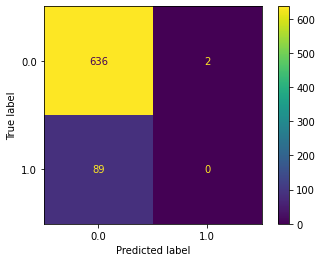

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       638
         1.0       0.00      0.00      0.00        89

    accuracy                           0.88       727
   macro avg       0.44      0.50      0.47       727
weighted avg       0.77      0.88      0.82       727



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

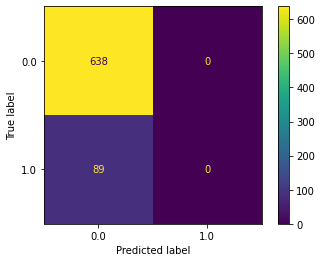

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       638
         1.0       0.00      0.00      0.00        89

    accuracy                           0.87       727
   macro avg       0.44      0.50      0.47       727
weighted avg       0.77      0.87      0.82       727



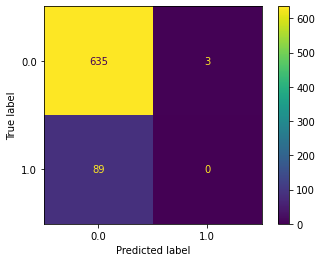

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       638
         1.0       0.00      0.00      0.00        89

    accuracy                           0.88       727
   macro avg       0.44      0.50      0.47       727
weighted avg       0.77      0.88      0.82       727



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

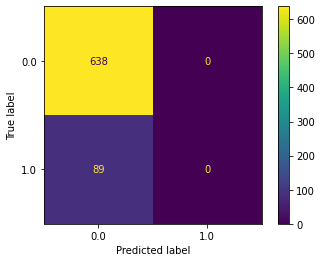

(2908, 25088) (2908, 1)
>Train: 0=2552, 1=356, Test: 0=639, 1=88
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       639
         1.0       0.00      0.00      0.00        88

    accuracy                           0.88       727
   macro avg       0.44      0.50      0.47       727
weighted avg       0.77      0.88      0.82       727



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

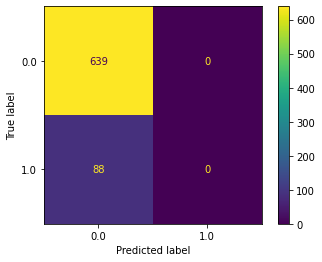

['Sequential', 57.17999999999999, nan, 46.7, 87.66000000000001, 43.9, 49.92]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

tf.random.set_seed(34)
np.random.seed(34)

def create_tuned():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(25088,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(2624, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model


estimator = KerasClassifier(build_fn=create_tuned, epochs=5, batch_size=64, verbose=20)
# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# print(X_aug.shape, Y_aug.shape)
kfold_score = evaluate_kfold(X, y, estimator, model_name='Sequential', X_aug=X_aug, y_aug=y_aug, cf=True, augment=False)

print(kfold_score)

# V3. Original + Aug

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
>Train: 0=8767, 1=1243, Test: 0=638, 1=89


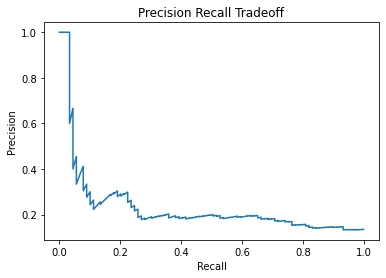

[88.2] [88.2] [65.4]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       638
         1.0       1.00      0.03      0.07        89

    accuracy                           0.88       727
   macro avg       0.94      0.52      0.50       727
weighted avg       0.90      0.88      0.83       727



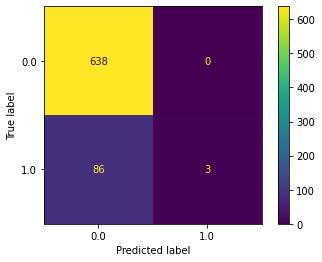

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
>Train: 0=8767, 1=1243, Test: 0=638, 1=89


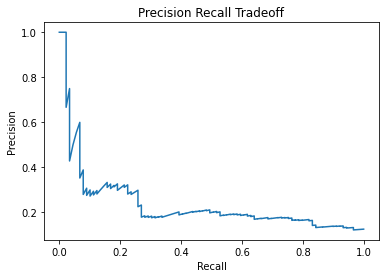

[88.2, 87.8] [88.2, 87.8] [65.4, 65.5]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       638
         1.0       0.00      0.00      0.00        89

    accuracy                           0.88       727
   macro avg       0.44      0.50      0.47       727
weighted avg       0.77      0.88      0.82       727



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


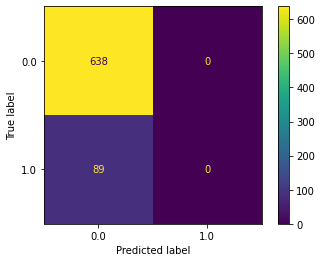

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
>Train: 0=8767, 1=1243, Test: 0=638, 1=89


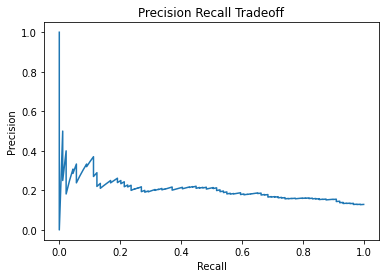

[88.2, 87.8, 87.5] [88.2, 87.8, 87.5] [65.4, 65.5, 66.0]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       638
         1.0       0.25      0.01      0.02        89

    accuracy                           0.87       727
   macro avg       0.56      0.50      0.48       727
weighted avg       0.80      0.87      0.82       727



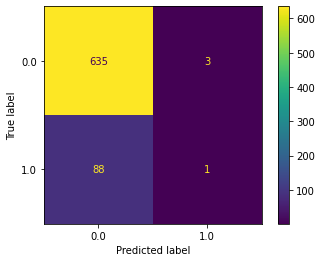

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
>Train: 0=8767, 1=1243, Test: 0=638, 1=89


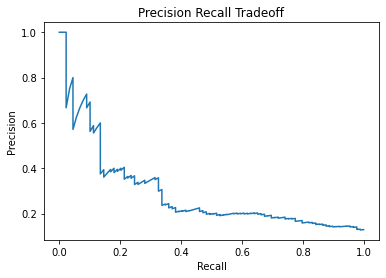

[88.2, 87.8, 87.5, 87.9] [88.2, 87.8, 87.5, 87.9] [65.4, 65.5, 66.0, 68.8]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       638
         1.0       1.00      0.01      0.02        89

    accuracy                           0.88       727
   macro avg       0.94      0.51      0.48       727
weighted avg       0.89      0.88      0.82       727



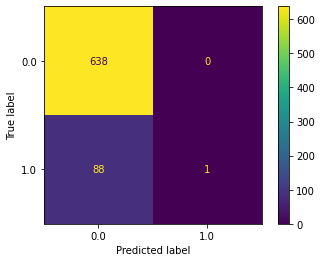

(2908, 25088) (2908, 1)
>Train: 0=2552, 1=356, Test: 0=639, 1=88
>Train: 0=8766, 1=1244, Test: 0=639, 1=88


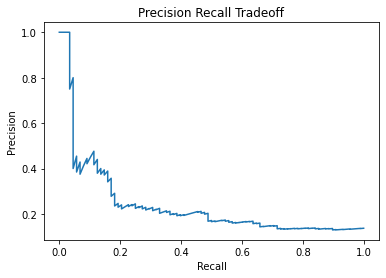

[88.2, 87.8, 87.5, 87.9, 88.3] [88.2, 87.8, 87.5, 87.9, 88.3] [65.4, 65.5, 66.0, 68.8, 62.8]
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       639
         1.0       1.00      0.03      0.07        88

    accuracy                           0.88       727
   macro avg       0.94      0.52      0.50       727
weighted avg       0.90      0.88      0.83       727



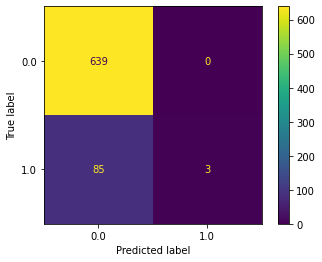

['Sequential', 65.7, nan, 48.52, 87.94, 87.94, 87.94]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

tf.random.set_seed(34)
np.random.seed(34)

def create_baseline():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(25088,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model


estimator = KerasClassifier(build_fn=create_baseline, epochs=5, batch_size=64, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# print(X_aug.shape, Y_aug.shape)
kfold_score = evaluate_kfold(X, y, estimator, model_name='Sequential', X_aug=X_aug, y_aug=y_aug, augment=True, cf=True)

print(kfold_score)

#V4. Aug + Tuned

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

tf.random.set_seed(34)
np.random.seed(34)

def create_baseline():

  my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(25088,), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(2624, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')])

  # Compile model
  my_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=[tf.keras.metrics.AUC()])
  
  return my_model


estimator = KerasClassifier(build_fn=create_baseline, epochs=25, batch_size=64, verbose=20)
# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

# print(X_aug.shape, Y_aug.shape)
kfold_score = evaluate_kfold(X, y, estimator, model_name='Sequential', X_aug=X_aug, y_aug=y_aug, augment=True, cf=False)

print(kfold_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
>Train: 0=8767, 1=1243, Test: 0=638, 1=89
Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       638
         1.0       1.00      0.03      0.07        89

    accuracy                           0.88       727
   macro avg       0.94      0.52      0.50       727
weighted avg       0.90      0.88      0.83       727

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
>Train: 0=8767, 1=1243, Test: 0=638, 1=89
Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93       638
         1.0       0.00      0.00      0.00        89

    accuracy                           0.88       727
   macro avg       0.44      0.50      0.47       727
weighted avg       0.77      0.88      0.82       727

(2908, 25088) (2908, 1)
>Train: 0=2553, 1=355, Test: 0=638, 1=89
>Train: 0=8767, 1=1243, Test: 0=638, 1=89
Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       638
         1.0       1.00      0.01      0.02        89

    accuracy                           0.88       727
   macro avg       0.94      0.51      0.48       727
wei

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




---

# Pretained VGG19 Experimental Fine-Tuning - Unfreeze layers


---



In [ ]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.layers import *
from keras.models import Model
from sklearn.metrics import classification_report
from imutils import paths

import tensorflow_datasets as tfds

In [ ]:
def plot_training(H, N, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
# import glob
# pop = glob.glob("gdrive/MyDrive/thesis/podcast_images/1/*.*")
# non_pop = glob.glob("gdrive/MyDrive/thesis/podcast_images/0/*.*")


# data = []
# labels = []

# for i in pop:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
#     image=np.array(image)
#     data.append(image)
#     labels.append(1)

# for i in non_pop:   
#     image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', target_size= (224,224))
#     image=np.array(image)
#     data.append(image)
#     labels.append(0)

# data = np.array(data)
# labels = np.array(labels)

# print(data)

# from sklearn.model_selection import train_test_split

# X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(2908, 224, 224, 3)

In [ ]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    "gdrive/MyDrive/thesis/podcast_images/",
    # "gdrive/MyDrive/thesis/augment/",
    subset="training",
    shuffle=True,
    seed=42,
    validation_split=0.2,
    image_size=(224, 224))

data = tf.keras.preprocessing.image_dataset_from_directory(
    "gdrive/MyDrive/thesis/podcast_images/",
    # "gdrive/MyDrive/thesis/augment/",
    subset="validation",
    shuffle=True,
    seed=42,
    validation_split=0.2,
    image_size=(224, 224))

Found 3635 files belonging to 2 classes.
Using 2908 files for training.
Found 3635 files belonging to 2 classes.
Using 727 files for validation.


In [ ]:
train.take(5)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# train_size = int(0.7 * 1208)
# # val_size = int(0.15 * 1208)
# test_size = int(0.3 * 1208)

# data = data.shuffle(1208)
# train_dataset = data.take(train_size)
# test_dataset = data.skip(train_size)
# # val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [ ]:
base_model2 = VGG19(weights='imagenet', include_top=False)
inputs = Input(shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the the base model
headModel = base_model2.output

print(headModel.shape)
# headModel = Flatten(name="flatten1")(headModel)
headModel = GlobalAveragePooling2D(name="avg_pool")(headModel)
# headModel = BatchNormalization()(headModel)
headModel = Dense(512, activation="relu")(headModel)
# headModel = Dropout(0.2)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model2.input, outputs=headModel)

for layer in model.layers[-20:]:
	layer.trainable = True

# opt = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
opt = tf.keras.optimizers.Adam()

# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC()])

model.fit(x=train, batch_size=128, epochs=20)



80150528/80134624 [==============================] - 0s 0us/step
(None, None, None, 512)
Epoch 1/20
91/91 [==============================] - 88s 521ms/step - loss: 6.8816 - auc: 0.4979
Epoch 2/20
91/91 [==============================] - 44s 477ms/step - loss: 0.3937 - auc: 0.5415
Epoch 3/20
91/91 [==============================] - 46s 492ms/step - loss: 0.3740 - auc: 0.5057
Epoch 4/20
91/91 [==============================] - 45s 488ms/step - loss: 0.3709 - auc: 0.4644
Epoch 5/20
91/91 [==============================] - 45s 490ms/step - loss: 0.3692 - auc: 0.4819
Epoch 6/20
91/91 [==============================] - 45s 490ms/step - loss: 0.3706 - auc: 0.4948
Epoch 7/20
91/91 [==============================] - 45s 490ms/step - loss: 0.3786 - auc: 0.5123
Epoch 8/20
91/91 [==============================] - 45s 483ms/step - loss: 3.0602 - auc: 0.4951
Epoch 9/20
91/91 [==============================] - 45s 483ms/step - loss: 0.4734 - auc: 0.4919
Epoch 10/20
91/91 [============================

KeyboardInterrupt: ignored

In [ ]:
loss, auc = model.evaluate(data)

8/8 [==============================] - 4s 326ms/step - loss: 0.5807 - auc_2: 0.4914


In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in base_model.layers[15:]:
	layer.trainable = True

# loop over the layers in the model and show which ones are trainable
# or not
for layer in base_model.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7f58451a1910>: False
<keras.layers.convolutional.Conv2D object at 0x7f5843cf6f90>: False
<keras.layers.convolutional.Conv2D object at 0x7f5843450690>: False
<keras.layers.pooling.MaxPooling2D object at 0x7f58433de690>: False
<keras.layers.convolutional.Conv2D object at 0x7f584025d410>: False
<keras.layers.convolutional.Conv2D object at 0x7f584025ed10>: False
<keras.layers.pooling.MaxPooling2D object at 0x7f5840265950>: False
<keras.layers.convolutional.Conv2D object at 0x7f5840268850>: False
<keras.layers.convolutional.Conv2D object at 0x7f58402750d0>: False
<keras.layers.convolutional.Conv2D object at 0x7f584026c650>: False
<keras.layers.convolutional.Conv2D object at 0x7f584027b510>: False
<keras.layers.pooling.MaxPooling2D object at 0x7f5840205610>: False
<keras.layers.convolutional.Conv2D object at 0x7f5840201750>: False
<keras.layers.convolutional.Conv2D object at 0x7f5840209250>: False
<keras.layers.convolutional.Conv2D object at 0

In [ ]:
# opt = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=opt,
                metrics=[tf.keras.metrics.AUC()])

model.fit(x=train, batch_size=64, epochs=10)

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
# print("[INFO] re-compiling model...")
# opt = SGD(lr=1e-4, momentum=0.9)
# model.compile(loss="categorical_crossentropy", optimizer=opt,
# 	metrics=["accuracy"])

Epoch 1/10
61/61 [==============================] - 154s 2s/step - loss: 0.5282 - auc_6: 0.4976
Epoch 2/10
61/61 [==============================] - 29s 455ms/step - loss: 0.5282 - auc_6: 0.4982
Epoch 3/10
61/61 [==============================] - 29s 456ms/step - loss: 0.5273 - auc_6: 0.5073
Epoch 4/10
61/61 [==============================] - 29s 456ms/step - loss: 0.5280 - auc_6: 0.5033
Epoch 5/10
61/61 [==============================] - 29s 455ms/step - loss: 0.5282 - auc_6: 0.4961
Epoch 6/10
61/61 [==============================] - 29s 455ms/step - loss: 0.5294 - auc_6: 0.4795
Epoch 7/10
61/61 [==============================] - 29s 454ms/step - loss: 0.5289 - auc_6: 0.4893
Epoch 8/10
61/61 [==============================] - 29s 455ms/step - loss: 0.5286 - auc_6: 0.4905
Epoch 9/10
61/61 [==============================] - 29s 456ms/step - loss: 0.5274 - auc_6: 0.5128
Epoch 10/10
61/61 [==============================] - 29s 454ms/step - loss: 0.5276 - auc_6: 0.5066


In [ ]:
loss, auc = model.evaluate(data)

16/16 [==============================] - 6s 335ms/step - loss: 0.5523 - auc_6: 0.5000


# Plot

## This plotting code is modified from online

In [ ]:
# #aggregating pr from diff models
# data = np.array([[0.77, 0.877], #lr
#                  [0.871, 0.883],  # vgg and aug tuned 100
#                  [0.822, 0.844],  #trill
#                  [0.860, 0.896]])  # trill and aug tuned 100

data = np.array([[0.49, 0.50], #lr
                 [0.83, 0.53],  # vgg and aug tuned 100
                #  [0.822, 0.844],  #trill
                 [0.73, 0.66]])  # trill and aug tuned 100
                                

length=len(data)
# Set plot parameters
fig, ax = plt.subplots()
width = 0.2 # width of bar
x = np.arange(length)

x_labels = ['Base w/LR', 'Trill + Aug\nw/Seq KT', 'VGG19 + Aug\nw/Seq KT']


ax.bar(x, data[:,0], width, color='#0F52BA', label='Precision') # yerr=data_std[:,0])
ax.bar(x + width, data[:,1], width, color='#6593F5', label='Recall') # yerr=data_std[:,1])

ax.set_ylabel('Metric Score')
ax.set_ylim(0, 1)
ax.set_xticks(x+width/2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Model')
ax.set_title('Binary Classification: Macro Precision vs Macro Recall')
ax.legend(prop={'size': 9.5}, ncol=2)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


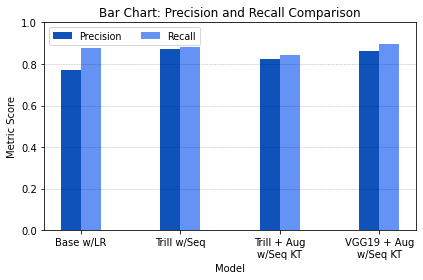

In [ ]:
fig

In [ ]:
data[:,0]

array([0.77 , 0.83 , 0.871])